# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

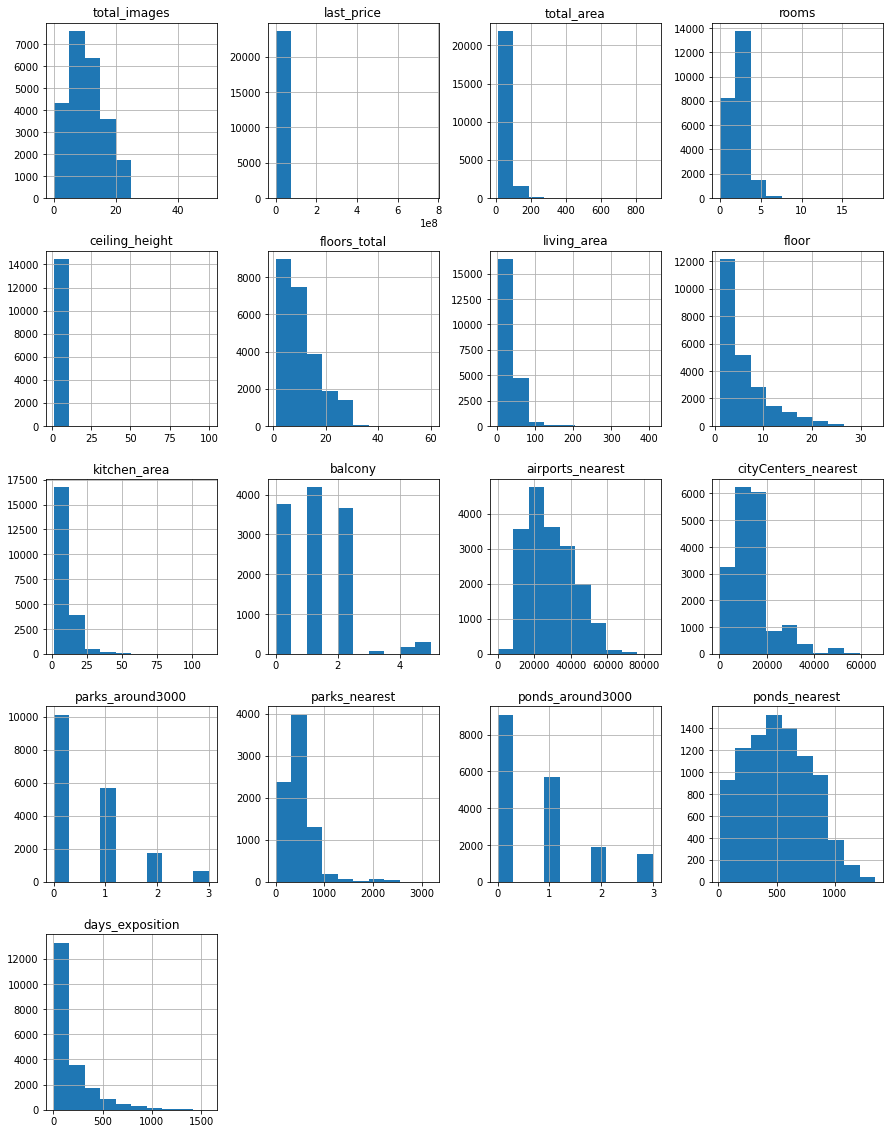

In [4]:
data.hist(figsize=(15, 20));

#### Вывод

В данных имеются пропуски. Нужно понять причину и устранить. Работать с данными все равно можно, потому что критично важных не задето или не так много.
Используется неправильные типы данных. На вскидку: это даты или категории, которые подразумевают другой тип значений(целочисленные, булевы)
По масштабам гисторгамм видно, что какие-то выбросы в данных есть, например, в цене, площади.
По каждому столбцу пройдусь отдельно в следующих разделах.

ОФФТОП: по дублям, странным значениям - из этих данных я этого не вижу. Еслл только чуть-чуть по гистограммам, масштаб непонятный, значит значение есть где-то там - так и писать? 

### Предобработка данных

#### Пропущенные значения

* ceiling_height        14504 non-null - оставил как есть
* floors_total          23613 non-null - оставил как есть
* living_area           21796 non-null - оставил как есть; пробовал вычитать из total_area kitchen_area, но новая жилая площадь получалось больше, старая в среднем 62,5 процента от нее, но это среднее
* is_apartment          2775 non-null  - оставил как есть 
* kitchen_area          21421 non-null - оставил как есть
* balcony               12180 non-null - заполнил 0 как в описании к заданию
* locality_name         23650 non-null - важный признак, пропусков мало, удалил строки без них, сбросил индекс
* airports_nearest      18157 non-null - оставил как есть
* cityCenters_nearest   18180 non-null - оставил как есть
* parks_around3000      18181 non-null - заполнил 0, так как нет строк где-бы было заполнены парки рядом и пустое количество тут
* parks_nearest         8079 non-null  - оставил как есть
* ponds_around3000      18181 non-null - сделал как с парками
* ponds_nearest         9110 non-null  - оставил как есть
* days_exposition       20518 non-null - оставил как есть

* Всё что касается пропусков в картографических данных - скорее всего технические ошибки. С другой стороны, возможны, исправления самим пользователям, в случае сомнений в тех данных, которые подгрузились, могли удалить сами.
* Пропуск в **locality_name** тоже скорее всего технический. По невнимательности не заполнить так мало раз достаточно важное поле - думаю сама система не пропускает такие объявления, поэтому так мало незаполненных из-за технических ошибок.
* **floors_total** - наоборот, достаточно важный критерий, характеризующий в том числе тип постройки, поэтому так мало пропущенных по невнимательности?
* **living_area** и **kitchen_area**, исходя из того, что пропуски отсутствуют в **total_area**, и то что пропусков тут примерно сколько указано апартаментов - это человеческий фактор.
* С **is_apartament** можно было бы поступить по аналогии с **balcony**, но если бы не указано было, как заполнить в описании к заданию, я бы оставил как есть. Может быть занудничаю, но на мой взгляд цена неправильного пропуска высока. Особенно с апартаментами - по обывательски - можно влететь на деньги, на какие-то проволочки юридические. Человеческий фактор, не указали, и скорее всего, что значит обычное жилье.
* **ceiling_height** скорее всего не знают, по невнимательности не указали, опять же натяжные потолки и т.д. + наличие фото. Существенный, но не самый важный критерий.

In [5]:
data['balcony'] = data['balcony'].fillna(0)

data = data.dropna(subset=['locality_name']) #мне кажется можно было оставить
data.reset_index(drop=True, inplace=True)


data.loc[(data['parks_around3000'] == True) & (data['parks_nearest'].isna())] # вроде бы правильно проверил
data['parks_around3000'] = data['parks_around3000'].fillna(0)

data.loc[(data['ponds_around3000'] == True) & (data['ponds_nearest'].isna())]
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

In [6]:
print(data['ceiling_height'].mean())
print(data['ceiling_height'].median())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

2.7712870945479646
2.65


#### Изменение типа данных

      last_price           float64
      first_day_exposition object
      floors_total         float64
      is_apartment         object 
      balcony              float64
      airports_nearest     float64   
      cityCenters_nearest  float64   
      parks_around3000     float64   
      parks_nearest        float64   
      ponds_around3000     float64   
      ponds_nearest        float64   
      days_exposition      float64
      
Все данные дробные значения хотел заменить на целочисленные, так как балконы 3,5 не бывает или очень большая редкость. Либо по содержанию не встретил дробных частей, как в ***days_exposition***, либо уже в метрах и сантиметры мало интересны, как в столбцах ***..._nearest***. К сожалению, NaN поддерживается только float, поэтому в некоторых оставил без изменений.

***is_apartment*** - оставил object, так как понимаю NaN в bool не переводится

***first_day_exposition*** - перевел в дату, чтобы удобнее было работать, извлекать данные. Съело часы, минуты и секунды, как понимаю некритично, они 0 были. 

#### Поиск и устранение дубликатов

In [8]:
def normalize_name(name):
    for i in range(len(name)):
        if name[i].isupper():
            name = name[i:]
            return name
        
data['locality_name'] = data['locality_name'].apply(normalize_name)            
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

#### Поиск аномальных значений

Проверил каждый столбик. Почти в каждом был ряд выбивающихся значений, например, площадь квартиры 900 метров, расстояние до аэропорта 80 км но при осмотре, учитывая названия населённых пунктов,соотношение жилой площади, площади кухни - всё в пределах допустимого. Пришлось работать с аномалиями только в ***ceiling_height*** - принял за опечатки, заменил, всё что больше 10 метров. Там где 14 метров потолки - обычная квратира, скорее всего в новостройке, компактный вариант.

22264    10.3
Name: ceiling_height, dtype: float64

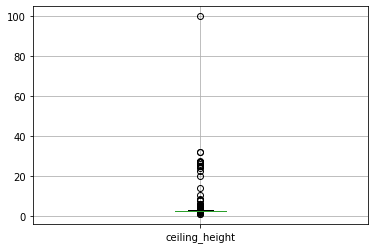

In [9]:
data.boxplot('ceiling_height')
data['ceiling_height'] = data['ceiling_height'].replace(25, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(27, 2.7)
data['ceiling_height'] = data['ceiling_height'].replace(24, 2.4)
data['ceiling_height'] = data['ceiling_height'].replace(26, 2.6)
data['ceiling_height'] = data['ceiling_height'].replace(20, 2.0)
data['ceiling_height'] = data['ceiling_height'].replace(32, 3.2)
data['ceiling_height'] = data['ceiling_height'].replace(22.6, 2.26)
data['ceiling_height'] = data['ceiling_height'].replace(27.5, 2.75)
data['ceiling_height'] = data['ceiling_height'].replace(25, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(100, 10)
data['ceiling_height'] = data['ceiling_height'].replace(14, 2.4)
data[data['ceiling_height'] > 10]['ceiling_height']


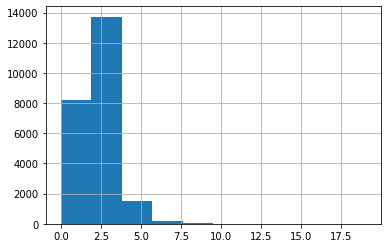

In [10]:
data['rooms'].hist();

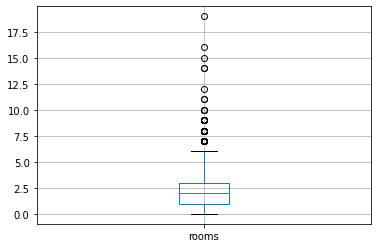

In [11]:
data.boxplot('rooms');

In [12]:
print(len(data.query('rooms > 7')))
data = data.query('rooms < 7')

31


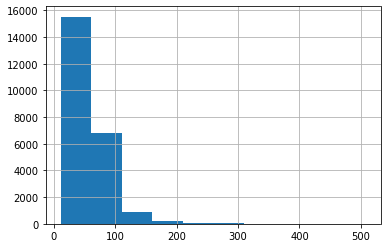

In [13]:
data['total_area'].hist();

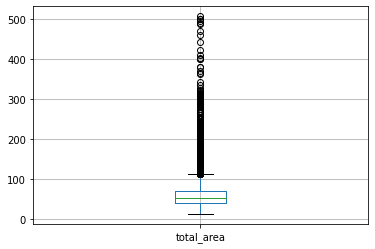

In [14]:
data.boxplot('total_area');

In [15]:
data = data.query('total_area <= 200')

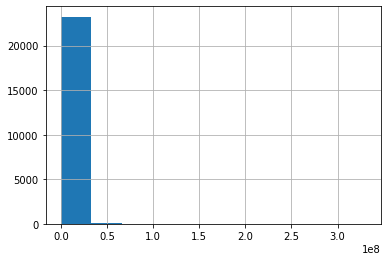

In [16]:
data['last_price'].hist();

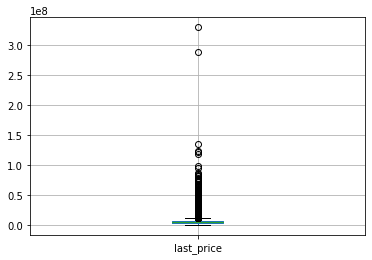

In [17]:
data.boxplot('last_price');

In [18]:
data = data.query('last_price <= 100000000 & last_price >= 100000')


Были удалены из 3 столбцов аномальные значения.
Были удалены аномалии более 6 комнат - 31 объявление, площадь более 200 метров - это порядка 1231 объявления, ценой выше 100 000 000 - это примерно 10
В сумме потери не превышают 10 процентов. Также вернулся из 4 раздела, так как на графике с усами увидел значение около 0 в цене. Удалил цену 12190

### Посчитайте и добавьте в таблицу новые столбцы

In [19]:
data['price_m'] = round(data['last_price'] / data['total_area'])
data['price_m'] = data['price_m'].astype('int')

data['day_posting'] = data['first_day_exposition'].dt.weekday
data['month_posting'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_posting'] = pd.DatetimeIndex(data['first_day_exposition']).year


def floor_types(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_types, axis=1)

data['center_km'] = round(data['cityCenters_nearest'] / 1000)

Были добавлены следующие столбцы:
**price_m** - средняя стоимость квадратного метра
**day_posting**, **month_posting**, **year_posting** - вычленили из даты день недели подачи объявления, месяц, год
**floor_type** - категориальное значение где находится этаж
**center_km** - добавил столбец в котором к км отразали расстояние до центра города

### Проведите исследовательский анализ данных

Плохо понимаю, что здесь конкретно от меня надо...

#### Общая площадь

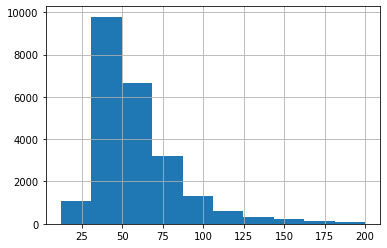

In [20]:
data['total_area'].hist();

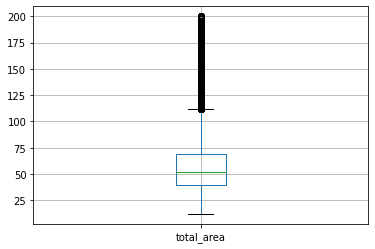

In [21]:
data.boxplot('total_area');

In [22]:
data[data['total_area'] >= 200].count()

total_images            4
last_price              4
total_area              4
first_day_exposition    4
rooms                   4
ceiling_height          4
floors_total            4
living_area             3
floor                   4
is_apartment            1
studio                  4
open_plan               4
kitchen_area            3
balcony                 4
locality_name           4
airports_nearest        4
cityCenters_nearest     4
parks_around3000        4
parks_nearest           3
ponds_around3000        4
ponds_nearest           4
days_exposition         4
price_m                 4
day_posting             4
month_posting           4
year_posting            4
floor_type              4
center_km               4
dtype: int64

Подавляющее большинство квартир имеет площадь до 100 метров это болше 21 тысячи из 23. Около 1000 квартит имеют площадь от 100 до 200 метров. 231 квартира больше 200 метров. Больше 400 метров есть 20 с чем-то квартир, это Санкт-Петербург, аномалия, но понятна и по другим данным, цене, например, логична

#### Жилая площадь

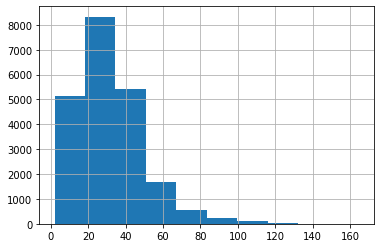

In [23]:
data['living_area'].hist();

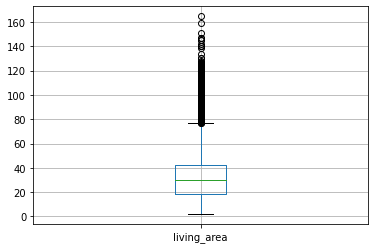

In [24]:
data.boxplot('living_area');

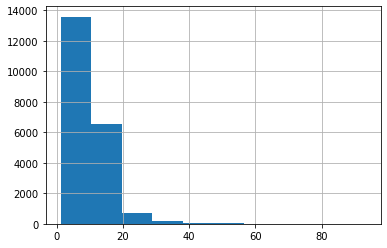

In [25]:
data['kitchen_area'].hist();

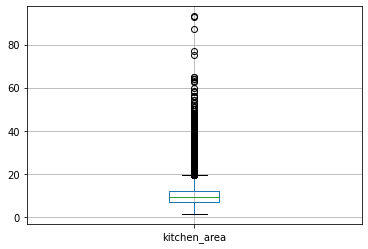

In [26]:
data.boxplot('kitchen_area');

Цифры отличаются, но графики выглядят очень похоже, что говорит о нормальности данных, логичности. Тут можно отметить, что норма жилой площади примерно 45 м, а кухни больше 22 м это редкость и относительная норма около 10 м.

#### Последняя цена

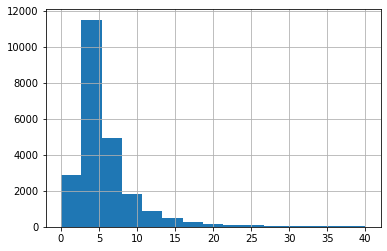

In [27]:
(data['last_price']/1000000).hist(range=(0, 40), bins=15);

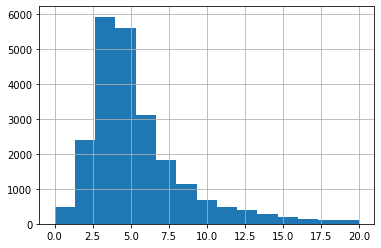

In [28]:
#код ревьюера
(data['last_price']/1000000).hist(range=(0, 20), bins=15);

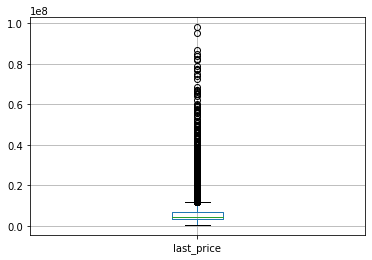

In [29]:
data.boxplot('last_price');

Непонимаю почему он мне выдаёт именно так, что нули не показаны. 10-20 миллионов это потолок для квартиры, большинство квартир можно купить за 10 млн. Попадаются квартиры и за 730 млн, Санкт-Петербург, исключение. Интересно, что самая большая по площади тоже выходит далеко за рамки усов, но не лидирует по цене.

27 миллионов это потолок для квартиры, большинство квартир можно купить до 8 млн.

#### Комнаты и высота потолков 

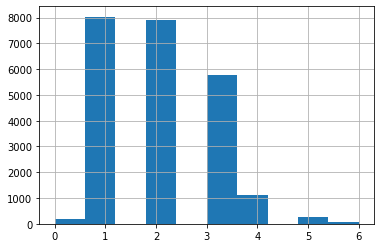

In [30]:
data['rooms'].hist();

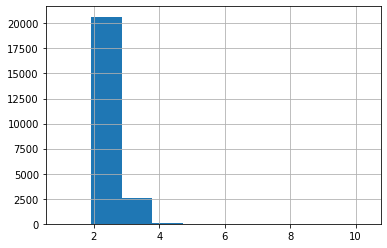

In [31]:
data['ceiling_height'].hist();

In [32]:
data[data['ceiling_height'] >= 6]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m,day_posting,month_posting,year_posting,floor_type,center_km
3470,3,1400000,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,False,False,7.3,0,Нурма,NaN,NaN,0,NaN,0,NaN,125.0,46667,4,3,2018,другой,NaN
5853,20,5650000,45.0,2018-08-15,1,8.3,16.0,19.3,14,NaN,False,False,8.3,1,Санкт-Петербург,13069.0,10763.0,0,NaN,1,613.0,14.0,125556,2,8,2018,другой,11.0
15717,14,5600000,67.0,2016-11-11,3,8.0,16.0,41.0,1,NaN,False,False,8.0,0,Санкт-Петербург,32691.0,11035.0,1,723.0,0,NaN,474.0,83582,4,11,2016,первый,11.0
17412,0,5350000,54.0,2015-06-16,2,8.0,5.0,29.0,2,NaN,False,False,NaN,1,Красное Село,24638.0,28062.0,0,NaN,0,NaN,469.0,99074,1,6,2015,другой,28.0
22264,20,5300000,45.0,2017-09-30,1,10.3,16.0,15.5,15,NaN,False,False,NaN,0,Санкт-Петербург,36353.0,11936.0,2,440.0,2,450.0,136.0,117778,5,9,2017,другой,12.0
22822,0,15000000,25.0,2018-07-25,1,10.0,5.0,14.0,5,True,False,False,11.0,5,Санкт-Петербург,34963.0,8283.0,1,223.0,3,30.0,19.0,600000,2,7,2018,последний,8.0


На мое удивление, что однушки не самые ходовые, а трешки. Больше 4 комнат редкость. Высота потолков больше ~3,5 м редкость(поправка на обработанные аномалии), исходя из этажности, в некоторых случаях цен, размера, можно предположить, что это правда. За исключением, может быть, первого случая.

#### Этаж 

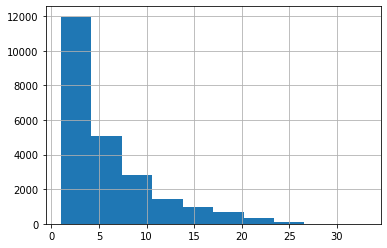

In [33]:
data['floor'].hist();

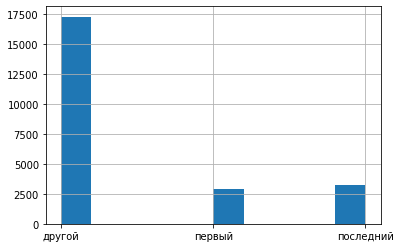

In [34]:
data['floor_type'].hist();

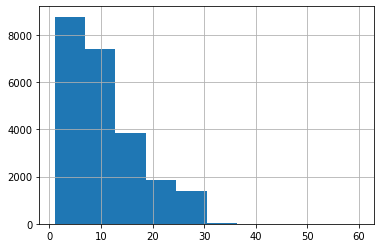

In [35]:
data['floors_total'].hist();

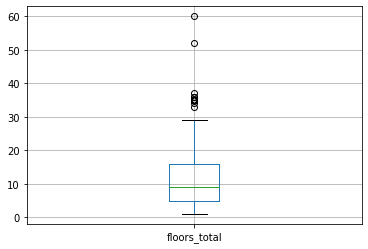

In [36]:
data.boxplot('floors_total');

Основная масса квартир приходится до 4 этажей. Думаю обусловлено тем, что есть посёлки и соответсвенно коттеджи / дома, возможно, в ходу вторичное жилье старой застройки. Можно отдельно проанализировать, смысла не вижу, но наблюдение интересное.
Небоскребов не так много, соответственно и продаж квартир в них меньше, хотя странно, что всё равно мало продают квартир на последних этажах. от 25 до 30 этажей зданий почти 2000, а продаж на этих этажах, около 100. По сравнению с 10 этажом - почти 3000 продаж - конечно, что для некоторых домов 10 это середина.
По типу этажа - всё ожидаемо, комментарии излишни. Первых и последних почти в 6 раз меньше, чем остальных, но примерно равное количество.

#### Расстояния до...

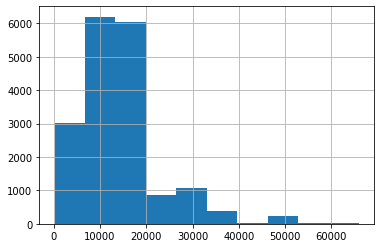

In [37]:
data['cityCenters_nearest'].hist();

In [38]:
data[data['cityCenters_nearest'] <= 20000]['locality_name'].value_counts()

Санкт-Петербург    14857
Парголово            222
Шушары               192
Name: locality_name, dtype: int64

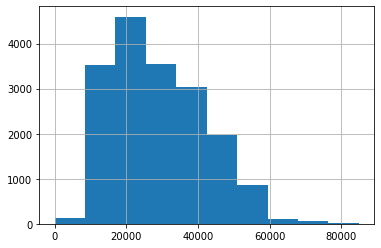

In [39]:
data['airports_nearest'].hist();

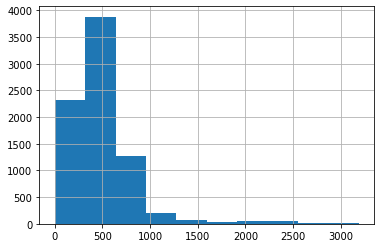

In [40]:
data['parks_nearest'].hist();

Большинство объвлений в базе, в черте Санкт-Петербурга в радиусе 20 км от центра. Интересно, что в 10 км от аэропорта мало продаж жилья, его там скорее всего и нет. И в подавляющем числе объвлений в 1 км от дома есть парк, потому что там где парк есть там указали, а это всего 1 / 3 от объвлений.

#### День публикации 

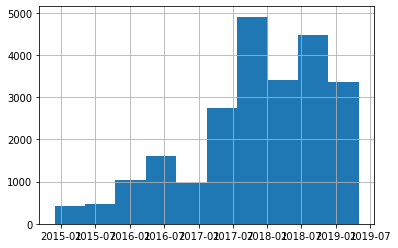

In [41]:
data['first_day_exposition'].hist();

База сама достаточно старая, однако рост кратный и объёмный во времени произошёл в 2017 году, и не падал. За год число объялений примерно в 4 раза.

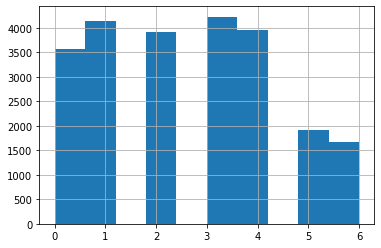

In [42]:
data['day_posting'].hist();

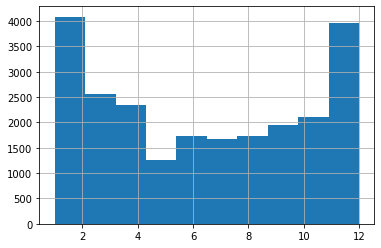

In [43]:
data['month_posting'].hist();

Объявления чащего всего публикуют по будням, причём можно сказать что равномерно. Так же равномерно и меньше в 2 раза по выходным. Пик объявлений приходится на зиму, и просадка почти в 2 раза на конец весны, лето.

Средние дни продаж:  179.5508704443458
Медиана дней продаж:  95.0


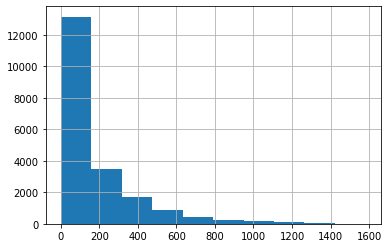

In [44]:
data['days_exposition'].hist();
print('Средние дни продаж: ', data['days_exposition'].mean())
print('Медиана дней продаж: ' , data['days_exposition'].median())

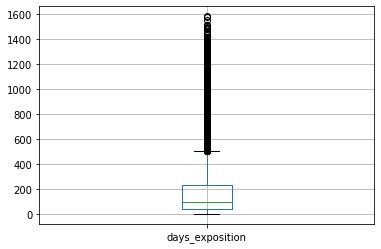

In [45]:
data.boxplot('days_exposition');

In [46]:
data[data['days_exposition'] <= 7]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m,day_posting,month_posting,year_posting,floor_type,center_km
11,9,3300000,44.0,2018-08-27,2,2.65,5.0,31.0,4,False,False,False,6.0,1,Ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0,75000,0,8,2018,другой,52.0
53,7,4300000,39.1,2017-11-10,1,2.65,25.0,15.4,13,NaN,False,False,15.5,2,Парголово,52611.0,18783.0,0,NaN,0,NaN,6.0,109974,4,11,2017,другой,19.0
62,0,4800000,78.6,2017-09-17,3,2.80,9.0,48.8,5,NaN,False,False,11.9,2,Сертолово,NaN,NaN,0,NaN,0,NaN,5.0,61069,6,9,2017,другой,NaN
94,3,3500000,29.5,2019-04-26,1,2.50,5.0,15.6,2,NaN,False,False,5.5,1,Санкт-Петербург,12921.0,7303.0,0,NaN,0,NaN,4.0,118644,4,4,2019,другой,7.0
106,9,10500000,124.1,2017-05-25,5,3.20,4.0,79.4,3,NaN,False,False,20.0,0,Санкт-Петербург,26825.0,5527.0,1,384.0,0,NaN,6.0,84609,3,5,2017,другой,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23454,11,3530000,36.1,2017-11-17,1,2.65,10.0,19.1,8,NaN,False,False,7.0,2,Санкт-Петербург,33091.0,14255.0,1,163.0,2,129.0,4.0,97784,4,11,2017,другой,14.0
23464,12,8300000,62.6,2017-02-15,2,2.70,16.0,32.9,8,False,False,False,11.3,2,Санкт-Петербург,29077.0,10858.0,0,NaN,0,NaN,7.0,132588,2,2,2017,другой,11.0
23547,10,3500000,43.5,2017-12-05,2,2.50,9.0,27.0,6,NaN,False,False,6.2,0,Санкт-Петербург,49094.0,16671.0,0,NaN,0,NaN,6.0,80460,1,12,2017,другой,17.0
23557,0,2850000,68.0,2018-07-29,1,3.00,5.0,41.0,3,NaN,False,False,10.0,0,Санкт-Петербург,38473.0,7740.0,2,560.0,3,327.0,4.0,41912,6,7,2018,другой,8.0


In [47]:
data['days_exposition'].max()

1580.0

Половина продаж происходит за 3 месяца. Медина 95. Среднее искажено из-за того, что объялвения некоторые весят по 4 с лишним года, 180 дней. ~180 дней является ещё интересным порогом, после которого количество продаж падает почти в 5 раз. При этом в течении года продаются большинство квартир.
Самая быстрая продажа за день. За неделю было продано почти 1000 квартир. Самая долгая продажа это 1580 дней. 

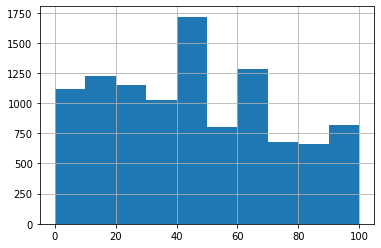

In [48]:
data['days_exposition'].hist(range=(0, 100));

#### Зависимость цены квартиры от ... 

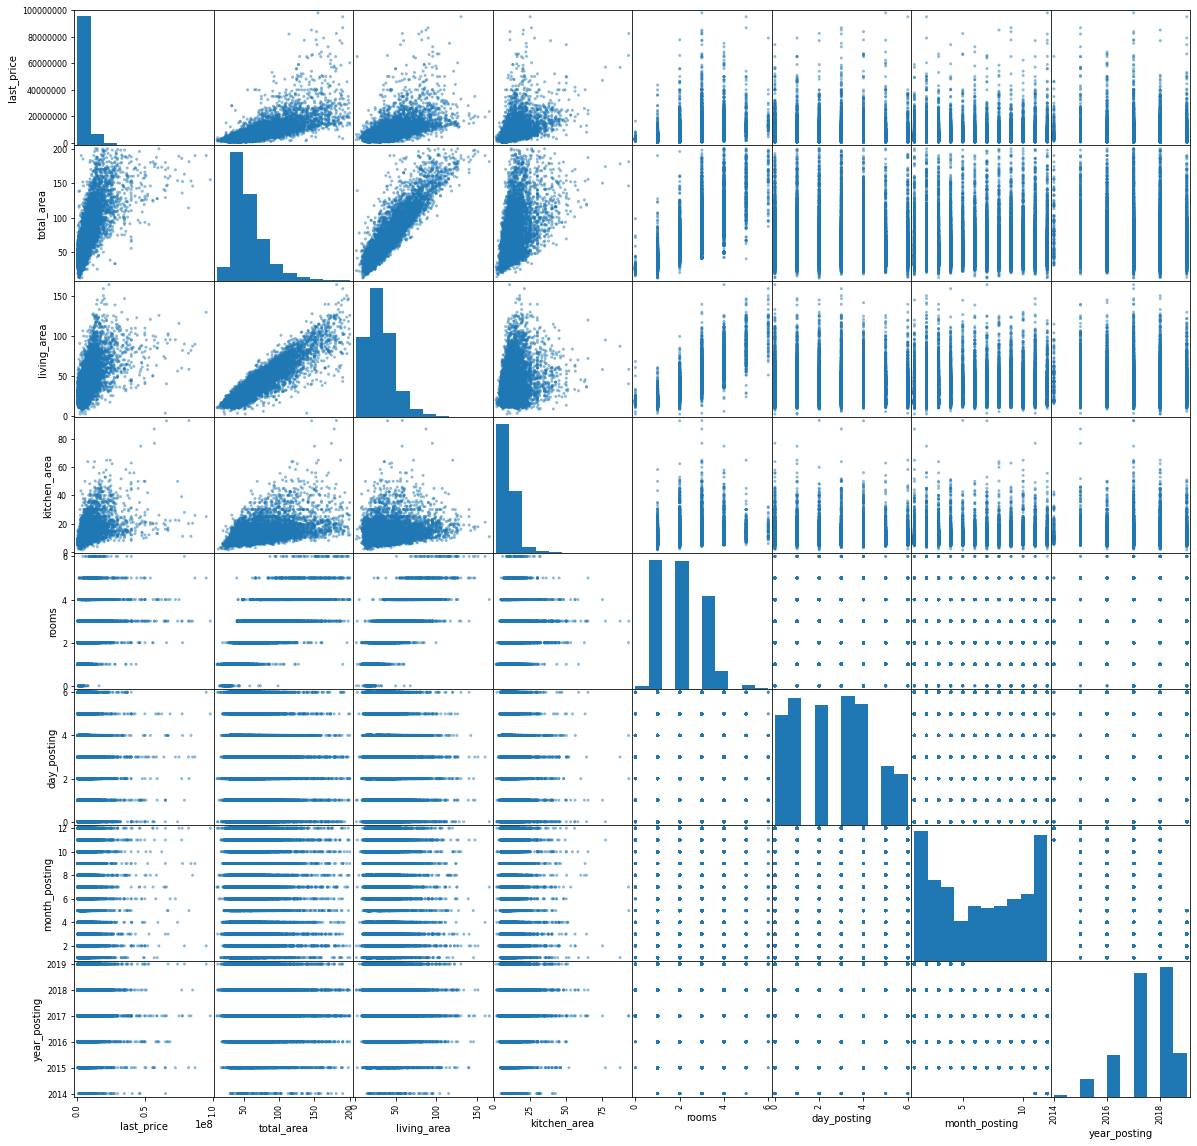

In [49]:
(pd.plotting
.scatter_matrix(data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'day_posting', 'month_posting', 'year_posting', 'floor_type']],
                figsize=(20,20))
);

К сожалению, почему-то игнорируется столбец **floor_type**, хотя на него хотелось / нужно было бы посмотреть. По графикам видно, что цена зависит от общей площади, и корреляция, прямая линия прослеживается. Соотвественно и жилая, и кухни демонстрируют ту же самую зависимость. Бывают исключения, что площадь очень большая, а цена даже не выбивается из середины.
Количество комнат очень напоминает нормальное распределение. До определённого этапа, это 5-6 комнат она растёт, а дальше снижается. 9 комнат можно купить по цене 3.
Между датой и ценой - зависимости я не увидел.

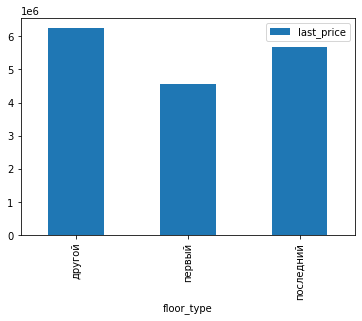

In [50]:
data.pivot_table(index='floor_type', values='last_price').plot.bar();

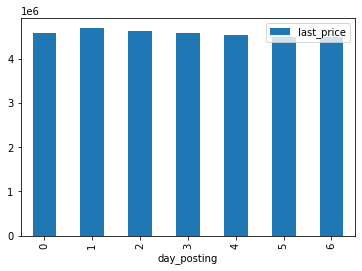

In [51]:
data.pivot_table(index='day_posting', values='last_price', aggfunc='median').plot.bar();

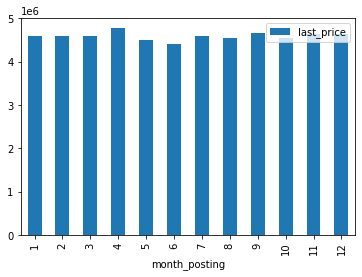

In [52]:
data.pivot_table(index='month_posting', values='last_price', aggfunc='median').plot.bar();

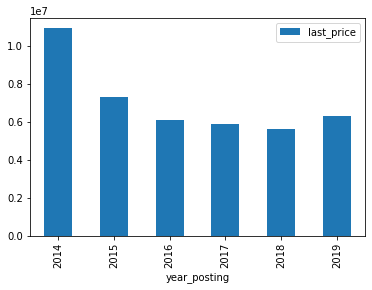

In [53]:
data.pivot_table(index='year_posting', values='last_price').plot.bar();

Первый этаж чуть-чуть дешевле, чем остальные. По годам цена снижалась, и немного выросла только в 2019. Зависимости между днями и месяцами не нашёл, на всякий случай даже посчитал медиану вместо среднего.

In [54]:
data['last_price'].corr(data['total_area'])

0.7314487642202407

In [55]:
data['last_price'].corr(data['living_area'])

0.6168054724510554

In [56]:
data['last_price'].corr(data['kitchen_area'])

0.5695909818098353

In [57]:
data['last_price'].corr(data['rooms'])

0.4296906401361916

Между площадями и ценой корреляция прослеживается сильней, чем для количества комнат. Самая большая корелляция, что ожидаемо и нормально между ценой и общей площадью

#### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [58]:
print(data.value_counts('locality_name').head(10))

(print('Средняя цена метра в Санкт-Петербурге: ', round(data[data['locality_name'] == 'Санкт-Петербург']['last_price'].sum() / 
       data[data['locality_name'] == 'Санкт-Петербург']['total_area'].sum()))
)
(print('Средняя цена метра в Мурино: ', round(data[data['locality_name'] == 'Мурино']['last_price'].sum() / 
       data[data['locality_name'] == 'Мурино']['total_area'].sum()))
)
(print('Средняя цена метра в Кудрово: ', round(data[data['locality_name'] == 'Кудрово']['last_price'].sum() / 
       data[data['locality_name'] == 'Кудрово']['total_area'].sum()))
)
(print('Средняя цена метра в Шушары: ', round(data[data['locality_name'] == 'Шушары']['last_price'].sum() / 
       data[data['locality_name'] == 'Шушары']['total_area'].sum()))
)
(print('Средняя цена метра в Всеволожск: ', round(data[data['locality_name'] == 'Всеволожск']['last_price'].sum() / 
       data[data['locality_name'] == 'Всеволожск']['total_area'].sum()))
)
(print('Средняя цена метра в Пушкин: ', round(data[data['locality_name'] == 'Пушкин']['last_price'].sum() / 
       data[data['locality_name'] == 'Пушкин']['total_area'].sum()))
)
(print('Средняя цена метра в Колпино: ', round(data[data['locality_name'] == 'Колпино']['last_price'].sum() / 
       data[data['locality_name'] == 'Колпино']['total_area'].sum()))
)
(print('Средняя цена метра в Парголово: ', round(data[data['locality_name'] == 'Парголово']['last_price'].sum() / 
       data[data['locality_name'] == 'Парголово']['total_area'].sum()))
)
(print('Средняя цена метра в Гатчина: ', round(data[data['locality_name'] == 'Гатчина']['last_price'].sum() / 
       data[data['locality_name'] == 'Гатчина']['total_area'].sum()))
)
(print('Средняя цена метра в Выборг: ', round(data[data['locality_name'] == 'Выборг']['last_price'].sum() / 
       data[data['locality_name'] == 'Выборг']['total_area'].sum()))
)



locality_name
Санкт-Петербург    15477
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Пушкин               364
Колпино              337
Парголово            326
Гатчина              307
Выборг               237
dtype: int64
Средняя цена метра в Санкт-Петербурге:  117537
Средняя цена метра в Мурино:  83414
Средняя цена метра в Кудрово:  93947
Средняя цена метра в Шушары:  76328
Средняя цена метра в Всеволожск:  67635
Средняя цена метра в Пушкин:  105208
Средняя цена метра в Колпино:  73843
Средняя цена метра в Парголово:  87691
Средняя цена метра в Гатчина:  68475
Средняя цена метра в Выборг:  57898


In [59]:
data.pivot_table(index='locality_name', values='price_m').sort_values(by='price_m')

,price_m
locality_name,
Старополье,11206.333333
Свирь,11481.500000
Вахнова Кара,11688.000000
Выскатка,12335.500000
Совхозный,12629.500000
...,...
Сестрорецк,101912.362637
Пушкин,103122.538462
Репино,104238.500000


Подавляющее большинство объявлений в Питере. Интересно, что в десятке по количеству, первое занимает Питер, последнее Выборг. И так же распределяется самая большая и маленькая стоимость метра в среднем. В Питере больше всего, в Выборге меньше всего.
Если брать в абсолютном виде - то самая маленькая цена за метр в среднем в Старополье в 10 раз меньше самой большой в Зеленогорске. 11206 против 115122

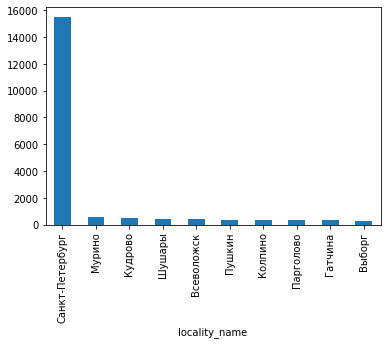

In [60]:
data.value_counts('locality_name').head(10).plot.bar();

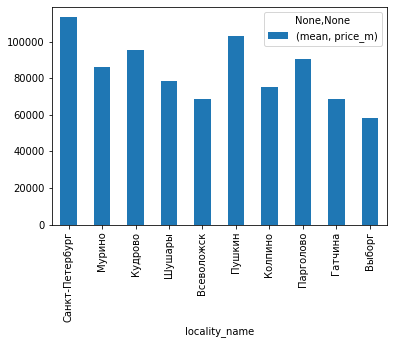

In [61]:
(
data
.pivot_table(index='locality_name', values='price_m', aggfunc=['count', 'mean'])
.sort_values(by=('count', 'price_m'),ascending=False)
.head(10)
.plot.bar(y=('mean', 'price_m'))
);

#### Средняя цена каждого километра

In [62]:
data_peter = data[data['locality_name'] == 'Санкт-Петербург']
(
data_peter[(~data_peter['last_price'].isna()) & (~data_peter['center_km'].isna())]['last_price'].sum() / 
data_peter[(~data_peter['last_price'].isna()) & (~data_peter['center_km'].isna())]['center_km'].sum()
)

616361.7227107548

In [63]:
data_peter['last_price'].corr(data_peter['center_km'])

-0.3747960747825232

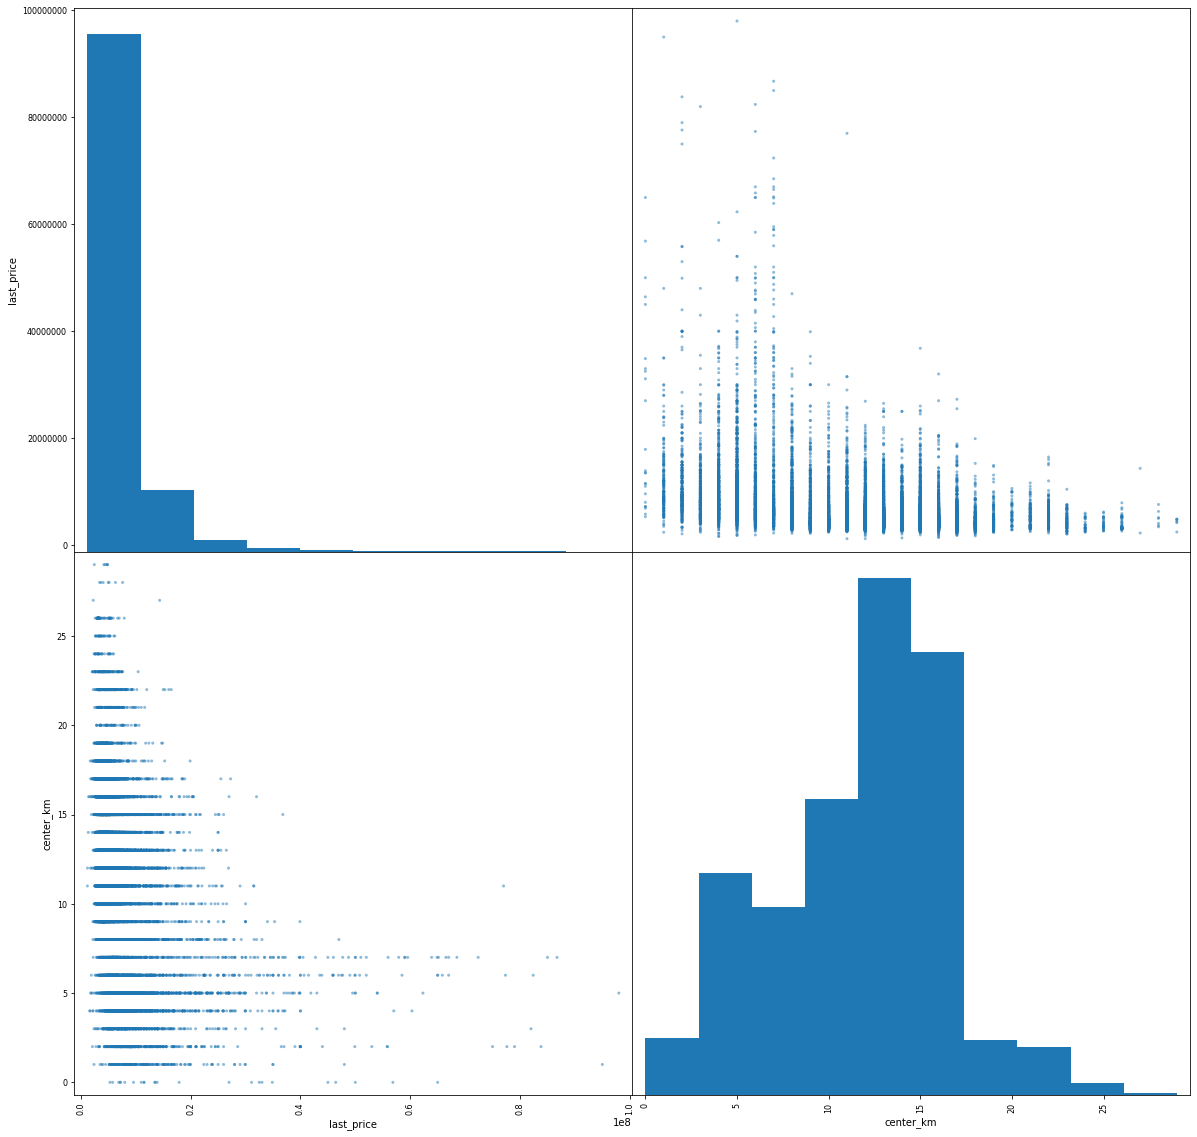

In [64]:
pd.plotting.scatter_matrix(data_peter[['last_price', 'center_km']], figsize=(20,20));

Я не совсем понимаю, зачем нужна эта средняя цена, ещё скорее всего, что неправильно её высчитал, если только ради интереса. А вот зависимости - квартиры дороже в радиусе 7 км, дальше можно провести черту и за редким исключением цена выше не поднимается.
Корелляция отрицательная, соответственно - одно растёт, другое снижается. Если снижается расстояние, то растёт цена и наоборот. Хотя корреляция сама по себе небольшая.

НОВЫЙ ВЫВОД НАПИШУ ЗДЕСЬ:
На мой взгляд медиана смотрится лучше, чем среднее, опишу его. Есть выброс на 0 километре, это какой-то интересный объект, возомжно, даде исторический. До 8 км цена скачет, после снижается. Есть 2 пика ещё на 20 км и 27 км. 27 км - скорее всего какой-то элитный дачный посёлок.

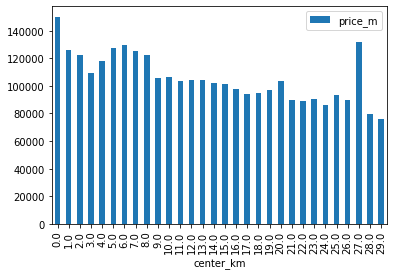

In [65]:
data_peter.pivot_table(index='center_km', values='price_m', aggfunc='median').plot.bar();

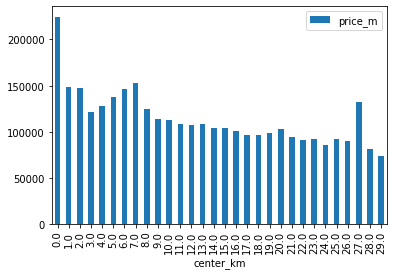

In [66]:
data_peter.pivot_table(index='center_km', values='price_m').plot.bar();

В среднем есть выброс на нулевом километре, какой-то особенный объект видимо. В целом разницы сильной нет, рисунки очень схожи. По мере удаления в целом цена снижается. Есть пики и такие же небольшие снижения - видимо там возрастает близость к другому центру.

### Общий вывод

При первом осмотре выявились не те типы данных - даты или категории, которые подразумевают другой тип значений(целочисленные, булевы, дата). По масштабам гисторгамм видно, что какие-то выбросы в данных есть, например, в цене, площади. По каждому столбцу прошелся отдельно в следующих разделах.

Всё что касается картографических данных - пропуски там, это технические ошибки. С теми данными, которые вносят пользователи - непонятно, что это - человеческий фактор или технический. Не сильно повлияло на исследование. Там где было возможно были устранены несоответствия типов данных. Очень много неявных дублей в названии населённых пунктов, дубли были устранены.

Были обнаружены и удалены аномалии в столбцах с ценой, общей площадью, комнатами. Также были устранены аномалии в данных с высотой потолков и заполнены медианой пропущенные значения.

Были добавлены следующие столбцы: **price_m** - средняя стоимость квадратного метра **day_posting**, **month_posting**, **year_posting** - вычленили из даты день недели подачи объявления, месяц, год **floor_type** - категориальное значение где находится этаж **center_km** - добавил столбец в котором к км отразали расстояние до центра города



* Подавляющее большинство квартир имеет площадь до 100 метров это болше 21 тысячи из 23. Около 1000 квартит имеют площадь от 100 до 200 метров. 231 квартира больше 200 метров. Больше 400 метров есть 20.

* Норма жилой площади примерно до 45 м, а кухни больше 22 м это редкость и относительная норма около 10 м.

* 27 миллионов это потолок для квартиры, большинство квартир можно купить до 8 млн. Попадаются квартиры и за 730 млн. Интересно, что самая большая по площади не лидирует по цене.

* Самые ходовые трешки. Больше 4 комнат редкость. Высота потолков больше ~3,5 м редкость(поправка на обработанные аномалии)

* Основная масса квартир приходится до 4 этажей. Думаю обусловлено тем, что есть посёлки и соответсвенно коттеджи / дома, возможно, в ходу вторичное жилье старой застройки. Небоскребов не так много, соответственно и продаж квартир в них меньше, хотя странно, что всё равно мало продают квартир на последних этажах. от 25 до 30 этажей зданий почти 2000, а продаж на этих этажах, около 100. По сравнению с 10 этажом - почти 3000 продаж - конечно, что для некоторых домов 10 это середина. По типу этажа - всё ожидаемо, комментарии излишни. Первых и последних почти в 6 раз меньше, чем остальных, но примерно равное количество.

* Большинство объвлений в базе, в черте Санкт-Петербурга в радиусе 20 км от центра. Интересно, что в 10 км от аэропорта мало продаж жилья, его там скорее всего и нет. И в подавляющем числе объвлений в 1 км от дома есть парк, потому что там где парк есть там указали, а это всего 1 / 3 от объвлений.

* База сама достаточно старая, однако рост кратный и объёмный во времени произошёл в 2017 году, и не падал. За год число объялений выросло примерно в 4 раза.

* Половина продаж происходит за 3 месяца. Медина 95. Среднее искажено из-за того, что объялвения некоторые весят по 4 с лишним года, 180 дней. ~180 дней является ещё интересным порогом, после которого количество продаж падает почти в 5 раз. При этом в течении года продаются большинство квартир. Самая быстрая продажа за день. За неделю было продано почти 1000 квартир. Самая долгая продажа это 1580 дней.

* По графикам видно, что цена зависит от общей площади, и корреляция, прямая линия прослеживается. Соотвественно и жилая, и кухни демонстрируют ту же самую зависимость. Бывают исключения, что площадь очень большая, а цена даже не выбивается из середины. Количество комнат очень напоминает нормальное распределение. До определённого этапа, это 5-6 комнат она растёт, а дальше снижается. 9 комнат можно купить по цене 3. Между датой и ценой - зависимости я не увидел.

* Объявления чащего всего публикуют по будням, причём можно сказать что равномерно. Так же равномерно и меньше в 2 раза по выходным. Пик объявлений приходится на зиму, и просадка почти в 2 раза на конец весны, лето.

* Первый этаж чуть-чуть дешевле, чем остальные. По годам цена снижалась, и немного выросла только в 2019. Зависимости между днями и месяцами не нашёл, на всякий случай даже посчитал медиану вместо среднего

* Между площадями и ценой корреляция прослеживается сильней, чем для количества комнат. Самая большая корелляция, что ожидаемо и нормально между ценой и общей площадью

* Подавляющее большинство объявлений в Питере. Интересно, что в десятке по количеству, первое занимает Питер, последнее Выборг. И так же распределяется самая большая и маленькая стоимость метра в среднем. В Питере больше всего, в Выборге меньше всего. Если брать в абсолютном виде - то самая маленькая цена за метр в среднем в Старополье в 10 раз меньше самой большой в Зеленогорске. 11206 против 115122

* 4.10. Средняя цена каждого километра. Есть выброс на 0 километре, это какой-то интересный объект, возомжно, даде исторический. До 8 км цена скачет, после снижается. Есть 2 пика ещё на 20 км и 27 км. 27 км - скорее всего какой-то элитный дачный посёлок. Корелляция отрицательная, соответственно - одно растёт, другое снижается. Хотя корреляция сама по себе небольшая. -0.37
